Loan defaults pose a significant challenge for financial institutions by affecting profitability and cash flow. Using historical loan repayment data, borrower profiles, and payment behaviours, many financial companies now use a smart loan recovery system to optimize collection efforts, minimize recovery costs, and maximize loan repayments.

In [46]:
import pandas as pd
df = pd.read_csv("loan-recovery.csv")
print(df.head())

  Borrower_ID  Age  Gender Employment_Type  Monthly_Income  Num_Dependents  \
0       BRW_1   59    Male        Salaried          215422               0   
1       BRW_2   49  Female        Salaried           60893               0   
2       BRW_3   35    Male        Salaried          116520               1   
3       BRW_4   63  Female        Salaried          140818               2   
4       BRW_5   28    Male        Salaried           76272               1   

  Loan_ID  Loan_Amount  Loan_Tenure  Interest_Rate  ... Collateral_Value  \
0    LN_1      1445796           60          12.39  ...     1.727997e+06   
1    LN_2      1044620           12          13.47  ...     1.180032e+06   
2    LN_3      1923410           72           7.74  ...     2.622540e+06   
3    LN_4      1811663           36          12.23  ...     1.145493e+06   
4    LN_5        88578           48          16.13  ...     0.000000e+00   

   Outstanding_Loan_Amount  Monthly_EMI  Payment_History Num_Missed_Paymen

To build a loan recovery system with Machine Learning, we will use a dataset containing borrower profiles, loan details, and repayment histories. This dataset includes critical attributes such as:

1. Demographic Information: Age, employment type, income level, and number of dependents.

2. Loan Details: Loan amount, tenure, interest rate, and collateral value.

3. Repayment History: Number of missed payments, days past due, and monthly EMI payments.

4. Collection Efforts: Collection methods used, number of recovery attempts, and legal actions taken.

5. Loan Recovery Status: Whether the loan was fully recovered, partially recovered, or remains outstanding.


Now, let’s move to analyzing this data in detail. I’ll first have a look at the distribution of the loan amount and its relationship with the monthly income

In [49]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd


fig = px.histogram(df, x='Loan_Amount', nbins=30, marginal="violin", opacity=0.7,
                   title="Loan Amount Distribution & Relationship with Monthly Income",
                   labels={'Loan_Amount': "Loan Amount (in $)", 'Monthly_Income': "Monthly Income"},
                   color_discrete_sequence=["royalblue"])

fig.add_trace(go.Scatter(
    x=sorted(df['Loan_Amount']),
    y=px.histogram(df, x='Loan_Amount', nbins=30, histnorm='probability density').data[0]['y'],
    mode='lines',
    name='Density Curve',
    line=dict(color='red', width=2)
))

scatter = px.scatter(df, x='Loan_Amount', y='Monthly_Income',
                     color='Loan_Amount', color_continuous_scale='Viridis',
                     size=df['Loan_Amount'], hover_name=df.index)

for trace in scatter.data:
    fig.add_trace(trace)

fig.update_layout(
    annotations=[
        dict(
            x=max(df['Loan_Amount']) * 0.8, y=max(df['Monthly_Income']),
            text="Higher Loan Amounts are linked to Higher Income Levels",
            showarrow=True,
            arrowhead=2,
            font=dict(size=12, color="red")
        )
    ],
    xaxis_title="Loan Amount (in $)",
    yaxis_title="Monthly Income (in $)",
    template="plotly_white",
    showlegend=True
)

fig.show()

The graph demonstrates a positive relationship between loan amounts and monthly income, indicating that individuals with higher income levels tend to secure larger loans. The density curve at the top shows the distribution of loan amounts, emphasizing that higher loan amounts are more frequent among higher income brackets.

It highlights the proportionality between income and loan size, which shows an income-based approach in loan approvals or customer profiling.

Analyzing Payment History

In [52]:
fig = px.histogram(df, x="Payment_History", color="Recovery_Status", barmode="group",
                   title="How Payment History Affects Loan Recovery Status",
                   labels={"Payment_History": "Payment History", "count": "Number of Loans"},
                   color_discrete_map={"Recovered": "green", "Not Recovered": "red"})

fig.update_layout(
    xaxis_title="Payment History",
    yaxis_title="Number of Loans",
    legend_title="Recovery Status",
    template="plotly_white",
        )

fig.show()

Loans with on-time payments are mostly fully recovered. Delayed payments result in a mix of partial and full recoveries, with some written off. Missed payments have a significantly lower recovery rate, with most loans ending up either partially recovered or written off.

In [54]:
fig = px.box(df, x="Recovery_Status", y="Num_Missed_Payments",
             title="How Missed Payments Affect Loan Recovery Status",
             labels={"Recovery_Status": "Recovery Status", "Num_Missed_Payments": "Number of Missed Payments"},
             color="Recovery_Status",
             color_discrete_map={"Recovered": "green", "Not Recovered": "red"},
             points="all")

fig.update_layout(
    xaxis_title="Recovery Status",
    yaxis_title="Number of Missed Payments",
    template="plotly_white"
)

fig.show()

Loans with partial recovery typically have up to 4 missed payments. Fully recovered loans tend to have fewer missed payments, mostly between 0 and 2. Written-off loans show a higher range of missed payments, with several exceeding 6. A higher number of missed payments significantly reduces the likelihood of full recovery and increases the chances of loans being written off.

In [56]:
fig = px.scatter(df, x='Monthly_Income', y='Loan_Amount',
                 color='Recovery_Status', size='Loan_Amount',
                 hover_data={'Monthly_Income': True, 'Loan_Amount': True, 'Recovery_Status': True},
                 title="How Monthly Income and Loan Amount Affect Loan Recovery",
                 labels={"Monthly_Income": "Monthly Income ($)", "Loan_Amount": "Loan Amount ($)"},
                 color_discrete_map={"Recovered": "green", "Not Recovered": "red"})

fig.add_annotation(
    x=max(df['Monthly_Income']), y=max(df['Loan_Amount']),
    text="Higher loans may still get recovered if income is high",
    showarrow=True,
    arrowhead=2,
    font=dict(size=12, color="red")
)

fig.update_layout(
    xaxis_title="Monthly Income ($)",
    yaxis_title="Loan Amount ($)",
    template="plotly_white"
)

fig.show()

Higher-income individuals are more likely to fully recover their loans, even for larger amounts. Borrowers in lower income brackets face a higher likelihood of loan write-offs or partial recovery. This trend highlights the impact of income on loan recovery, as higher earnings lead to better repayment outcomes and fewer write-offs, even for substantial loans.

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
            'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 'Num_Missed_Payments', 'Days_Past_Due']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

C:\Users\Asus\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



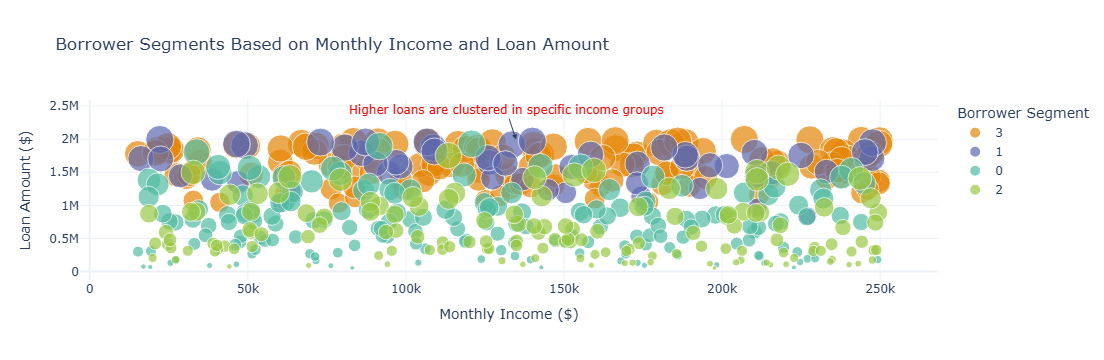

In [81]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Borrower_Segment'] = kmeans.fit_predict(df_scaled)

fig = px.scatter(df, x='Monthly_Income', y='Loan_Amount',
                 color=df['Borrower_Segment'].astype(str), size='Loan_Amount',
                 hover_data={'Monthly_Income': True, 'Loan_Amount': True, 'Borrower_Segment': True},
                 title="Borrower Segments Based on Monthly Income and Loan Amount",
                 labels={"Monthly_Income": "Monthly Income ($)", "Loan_Amount": "Loan Amount ($)", "Borrower_Segment": "Segment"},
                 color_discrete_sequence=px.colors.qualitative.Vivid)

fig.add_annotation(
    x=df['Monthly_Income'].mean(), y=df['Loan_Amount'].max(),
    text="Higher loans are clustered in specific income groups",
    showarrow=True,
    arrowhead=2,
    font=dict(size=12, color="red")
)

fig.update_layout(
    xaxis_title="Monthly Income ($)",
    yaxis_title="Loan Amount ($)",
    template="plotly_white",
    legend_title="Borrower Segment"
)

fig.show()

Segment 1 borrowers take on moderate to high loan amounts, indicating financial stability. The Segment 0 clusters around lower income levels and moderate loan sizes, reflecting potential financial strain. Segment 2 borrowers distribute evenly across the graph, representing a balanced but cautious group. Meanwhile, Segment 3 borrowers concentrate in high-loan areas, especially within specific high-income ranges, highlighting their susceptibility to default despite higher incomes.

Let’s name these segments according to the clusters they represent:

In [85]:
# updating segment names
df['Segment_Name'] = df['Borrower_Segment'].map({
    0: 'Moderate Income, High Loan Burden',
    1: 'High Income, Low Default Risk',
    2: 'Moderate Income, Medium Risk',
    3: 'High Loan, Higher Default Risk'
})

Now, we will use our segments to build a classification model to flag the borrowers with high default risk. Once the model finds the borrowers with a high default risk, we will assign a loan recovery strategy based on the level of the risk of the borrower. Let’s train the model first:

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df['High_Risk_Flag'] = df['Segment_Name'].apply(lambda x: 1 if x in ['High Loan, Higher Default Risk', 'Moderate Income, High Loan Burden'] else 0)

# selecting features for the model
features = ['Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
            'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 'Num_Missed_Payments', 'Days_Past_Due']
X = df[features]
y = df['High_Risk_Flag']

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# training the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# get risk scores (probability of being high risk)
risk_scores = rf_model.predict_proba(X_test)[:, 1]  # probability of high risk

# add risk scores and flags to test data
df_test = X_test.copy()
df_test['Risk_Score'] = risk_scores
df_test['Predicted_High_Risk'] = (df_test['Risk_Score'] > 0.5).astype(int)  # Threshold at 50% probability

# merging with borrower details
df_test = df_test.merge(df[['Borrower_ID', 'Segment_Name', 'Recovery_Status', 'Collection_Method', 'Collection_Attempts', 'Legal_Action_Taken']],
                        left_index=True, right_index=True)

we first labelled borrowers as high-risk based on their segment classification. Then, we selected key financial and behavioural features to train a Random Forest Classifier. After splitting the data into training and testing sets, we trained the model to predict the probability of a borrower defaulting. We then applied this model to the test data to generate risk scores and classify borrowers as high-risk or low-risk based on a probability threshold. Finally, we merged these predictions with borrower details to enable data-driven recovery strategies.

In [91]:
# creating a new column for the dynamic recovery strategy based on risk scores
def assign_recovery_strategy(risk_score):
    if risk_score > 0.75:
        return "Immediate legal notices & aggressive recovery attempts"
    elif 0.50 <= risk_score <= 0.75:
        return "Settlement offers & repayment plans"
    else:
        return "Automated reminders & monitoring"

df_test['Recovery_Strategy'] = df_test['Risk_Score'].apply(assign_recovery_strategy)

df_test.head()

,Age,Monthly_Income,Loan_Amount,Loan_Tenure,Interest_Rate,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Num_Missed_Payments,Days_Past_Due,Risk_Score,Predicted_High_Risk,Borrower_ID,Segment_Name,Recovery_Status,Collection_Method,Collection_Attempts,Legal_Action_Taken,Recovery_Strategy
436,25,156826,1510049,60,16.22,8.373402e+05,3.296001e+05,5493.34,1,179,0.42,0,BRW_437,"High Loan, Higher Default Risk",Partially Recovered,Legal Notice,7,No,Automated reminders & monitoring
448,57,33752,1803767,12,8.30,0.000000e+00,4.411477e+05,36762.31,0,0,0.64,1,BRW_449,"Moderate Income, High Loan Burden",Fully Recovered,Calls,2,No,Settlement offers & repayment plans
88,27,71503,1898058,24,12.59,1.087594e+06,4.227607e+05,17615.03,2,179,0.76,1,BRW_89,"High Loan, Higher Default Risk",Fully Recovered,Debt Collectors,3,No,Immediate legal notices & aggressive recovery ...
145,59,215641,1492181,36,15.85,1.340937e+06,1.337482e+06,37152.29,3,125,0.32,0,BRW_146,"High Income, Low Default Risk",Fully Recovered,Calls,3,No,Automated reminders & monitoring
344,52,106658,1958911,36,12.09,2.128380e+06,1.592191e+06,44227.52,0,0,0.09,0,BRW_345,"High Income, Low Default Risk",Fully Recovered,Calls,0,No,Automated reminders & monitoring


Here, we defined a function that categorizes borrowers into three recovery approaches:

immediate legal action for high-risk borrowers (risk score > 0.75),
settlement offers and repayment plans for moderate-risk borrowers (0.50 – 0.75),
and automated reminders for low-risk borrowers (<0.50).
This function was applied to the test dataset to assign a personalized recovery strategy to each borrower to ensure cost-effective and targeted loan recovery efforts.

So, this is how you can build a smart loan recovery system with Machine Learning.

Summary
So, by leveraging borrower profiles, payment behaviours, and clustering techniques, we can build a smart loan recovery system to identify high-risk borrowers early and assign targeted recovery strategies based on risk levels. I hope you liked this article on building a smart loan recovery system with Machine Learning.